<a href="https://colab.research.google.com/github/maderix/python_ray_tracing/blob/master/python_gpu_ray_tracing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!curl https://colab.chainer.org/install | CUPY_VERSION="==8.0.0b2" sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   3457      0 --:--:-- --:--:-- --:--:--  3449
********************************************************************************
GPU is not enabled!
Open "Runtime" > "Change runtime type" and set "Hardware accelerator" to "GPU".
********************************************************************************


In [0]:
from PIL import Image
from functools import reduce
import numpy as np
import numpy as onp
import time
import numbers
import math
import matplotlib.pyplot as plt
%matplotlib inline


In [0]:
def extract(cond, x):
    if isinstance(x, numbers.Number):
        return x
    else:
        return np.extract(cond, x)

class vec3():
    def __init__(self, x, y, z):
        (self.x, self.y, self.z) = (x, y, z)
    def __mul__(self, other):
        return vec3(self.x * other, self.y * other, self.z * other)
    def __add__(self, other):
        return vec3(self.x + other.x, self.y + other.y, self.z + other.z)
    def __sub__(self, other):
        return vec3(self.x - other.x, self.y - other.y, self.z - other.z)
    def dot(self, other):
        return (self.x * other.x) + (self.y * other.y) + (self.z * other.z)
    def __abs__(self):
        return self.dot(self)
    def norm(self):
        mag = np.sqrt(abs(self))
        return self * (1.0 / np.where(mag == 0, 1, mag))
    def components(self):
        return (self.x, self.y, self.z)
    def extract(self, cond):
        return vec3(extract(cond, self.x),
                    extract(cond, self.y),
                    extract(cond, self.z))
    def place(self, cond):
        r = vec3(np.zeros(cond.shape), np.zeros(cond.shape), np.zeros(cond.shape))
        np.place(r.x, cond, self.x)
        np.place(r.y, cond, self.y)
        np.place(r.z, cond, self.z)
        return r
rgb = vec3

In [0]:
(w, h) = (900, 900)         # Screen size
#point lights
lights = [
          (vec3(5, 5, -10),rgb(0.2,0.1,0.2)),
          (vec3(10, 5, -10),rgb(0.1,0.1,0.1)),
          (vec3(10, 5, -30),rgb(0.1,0.1,0.1))
]
eye_pos = vec3(0, 0.35, -1)     # Eye position
FARAWAY = math.inf          # an implausibly huge distance

In [0]:
def raytrace(O, D, scene, bounce,lights):
    # O is the ray origin, D is the normalized ray direction
    # scene is a list of Sphere objects (see below)
    # bounce is the number of the bounce, starting at zero for camera rays

    distances = [s.intersect(O, D) for s in scene]
    nearest = reduce(np.minimum, distances)
    color = rgb(0, 0, 0)
    for (s, d) in zip(scene, distances):
        hit = (nearest != FARAWAY) & (d == nearest)
        if np.any(hit):
            dc = extract(hit, d)
            Oc = O.extract(hit)
            Dc = D.extract(hit)
            cc = s.light(Oc, Dc, dc, scene, bounce, lights)
            color += cc.place(hit)
    return color

class Sphere:
    def __init__(self, center, r, diffuse, mirror = 0.5):
        self.c = center
        self.r = r
        self.diffuse = diffuse
        self.mirror = mirror

    def intersect(self, O, D):
        b = 2 * D.dot(O - self.c)
        c = abs(self.c) + abs(O) - 2 * self.c.dot(O) - (self.r * self.r)
        disc = (b ** 2) - (4 * c)
        sq = np.sqrt(np.maximum(0, disc))
        h0 = (-b - sq) / 2
        h1 = (-b + sq) / 2
        h = np.where((h0 > 0) & (h0 < h1), h0, h1)
        pred = (disc > 0) & (h > 0)
        return np.where(pred, h, FARAWAY)

    def diffusecolor(self, M):
        return self.diffuse

    def light(self, O, D, d, scene, bounce, lights):
      # Ambient
      color = rgb(0.0,0.0,0.0)
      for L in lights:
        color += L[1]
        M = (O + D * d)                         # intersection point
        N = (M - self.c) * (1. / self.r)        # normal
        toL = (L[0] - M).norm()                    # direction to light
        toO = (eye_pos - M).norm()                    # direction to ray origin
        nudged = M + N * .0001                  # M nudged to avoid itself

        # Shadow: find if the point is shadowed or not.
        # This amounts to finding out if M can see the light
        light_distances = [s.intersect(nudged, toL) for s in scene]
        light_nearest = reduce(np.minimum, light_distances)
        seelight = light_distances[scene.index(self)] == light_nearest

        # Lambert shading (diffuse)
        lv = np.maximum(N.dot(toL), 0)
        color += self.diffusecolor(M) * lv * seelight

        # Reflection
        if bounce < 1:
            rayD = (D - N * 2 * D.dot(N)).norm()
            color += raytrace(nudged, rayD, scene, bounce + 1,lights) * self.mirror

        # Blinn-Phong shading (specular)
        phong = N.dot((toL + toO).norm())
        color += rgb(1, 1, 1) * np.power(np.clip(phong, 0, 1), 50) * seelight
      return color

class CheckeredSphere(Sphere):
    def diffusecolor(self, M):
        checker = ((M.x * 2).astype(int) % 2) == ((M.z * 2).astype(int) % 2)
        return self.diffuse * checker

scene = [
    Sphere(vec3(.75, .1, 1), .6, rgb(0, 0, 1)),
    Sphere(vec3(-.75, .1, 2.25), .6, rgb(.5, .223, .5)),
    Sphere(vec3(-2.75, .1, 3.5), .6, rgb(1, 1, .184)),
    Sphere(vec3(-4.75, .1, 3.5), .6, rgb(1, .572, .184)),
    CheckeredSphere(vec3(0,-99999.5, 0), 99999, rgb(.75, .75, .75), 0.25),
    ]


In [0]:
r = float(w) / h
# Screen coordinates: x0, y0, x1, y1.
S = (-1, 1 / r + .25, 1, -1 / r + .25)
x = np.tile(np.linspace(S[0], S[2], w), h)
y = np.repeat(np.linspace(S[1], S[3], h), w)

t0 = time.time()
Q = vec3(x, y, 0)
color = raytrace(eye_pos, (Q - eye_pos).norm(), scene,bounce=0,lights=lights)
print ("Took", time.time() - t0)

Took 2.504704475402832


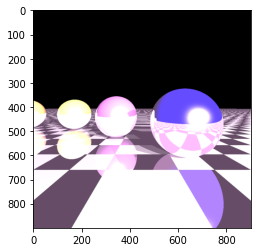

In [0]:
pixels = [Image.fromarray((255 * onp.clip(c, 0, 1).reshape((h, w))).astype(onp.uint8), "L") for c in color.components()]
pixels = Image.merge("RGB", pixels)
plt.imshow(onp.array(pixels))